In [2]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("vlag"))

In [3]:
from datetime import datetime, timedelta

# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [4]:
import yfinance as yf

# set the end date to today
end_date = datetime.today()
# set the start date to 5 years ago
start_date = end_date - timedelta(days=5 * 365)
print(start_date)

2019-09-06 19:32:30.048132


In [5]:
# list of tickers
tickers = [
    "QQQ",  # Invesco QQQ Trust Nasdaq 100
    # "SHV",  # iShares Short Treasury Bond ETF
    "TLT",  # iShares 20+ Year Treasury Bond ETF
    # "DIS",  # Disney
    "PFE",  # Phizer
    "T",  # AT&T
    "GSK",  #
    "LVS",  # Las Vegas Sand Corp
    "OXY",  # Occidental Petroleum Corporation
    # 'MMM',  # 3M
    "KO",  # Coca-Cola
    "KHC",  # Kraft Heinz
    "ABT",  # Abbott Labs
    # "CCL",  # Carnival Corporation
]
market = ["^GSPC"]

close_df = pd.DataFrame()
close_df = yf.download(tickers, start=start_date, end=end_date)["Close"]
market_df = yf.download(market, start=start_date, end=end_date)["Close"]

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
close_df.tail()

Ticker,ABT,GSK,KHC,KO,LVS,OXY,PFE,QQQ,T,TLT
Date,,,,,,,,,,
2024-08-28,112.900002,43.900002,35.389999,71.750000,39.009998,56.779999,28.750000,471.350006,19.820,97.849998
2024-08-29,112.760002,43.740002,35.259998,72.050003,38.639999,57.209999,28.719999,470.660004,19.760,97.529999
2024-08-30,113.269997,43.910000,35.430000,72.470001,38.990002,56.980000,29.010000,476.269989,19.900,96.489998
2024-09-03,114.660004,43.439999,35.590000,73.010002,38.680000,55.400002,28.299999,461.809998,20.430,97.750000
2024-09-04,113.824997,43.970001,35.945000,71.985001,39.950001,55.069901,28.450001,462.109985,20.525,98.660004


In [7]:
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired"))

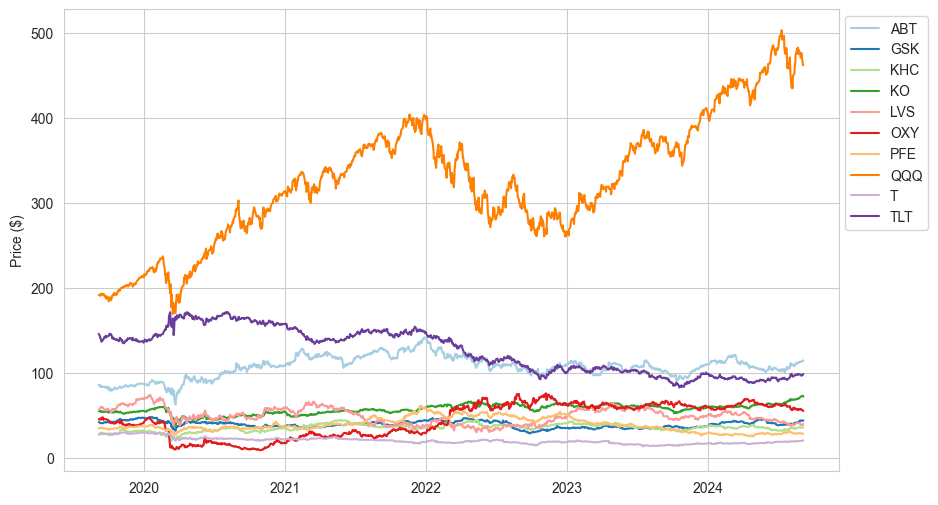

In [8]:
fig_prices, ax = plt.subplots(figsize=(10, 6))
for _c in close_df.columns:
    ax.plot(close_df[_c], label=_c)

ax.set_ylabel("Price ($)")
ax.legend(loc="best", bbox_to_anchor=(1, 1))

# fig_prices

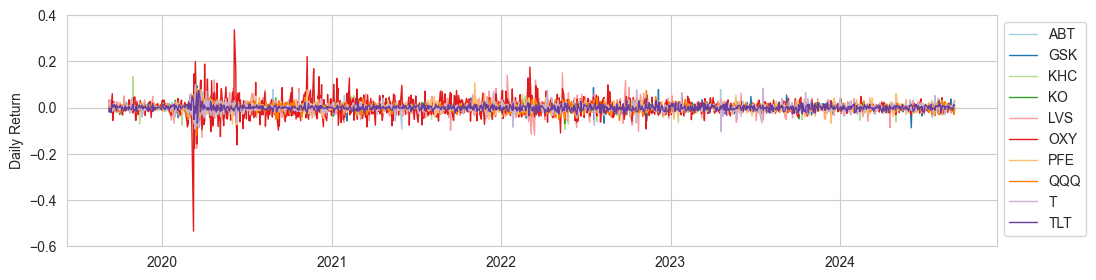

In [9]:
fig_daily_return, ax = plt.subplots(figsize=(12, 3))
for _c in close_df.columns:
    ax.plot(close_df[_c].pct_change(), label=_c, linewidth=1)
ax.set_ylim([-0.6, 0.4])
ax.set_ylabel("Daily Return")
ax.legend(loc="best", bbox_to_anchor=(1, 1))

In [10]:
# annulized daily returns
close_df.pct_change().mean() * 252

Ticker
ABT    0.090323
GSK    0.036734
KHC    0.095208
KO     0.074887
LVS    0.031358
OXY    0.251523
PFE   -0.002509
QQQ    0.209178
T     -0.022237
TLT   -0.062247
dtype: float64

In [11]:
daily_returns = close_df.pct_change()

# annulized volatility
daily_returns.std() * np.sqrt(252)

Ticker
ABT    0.261582
GSK    0.236153
KHC    0.283054
KO     0.207828
LVS    0.446804
OXY    0.631957
PFE    0.272290
QQQ    0.254394
T      0.266533
TLT    0.179520
dtype: float64

In [12]:
# individual Sharpe ratios
(close_df.pct_change().mean() * 252 - 0.03) / (daily_returns.std() * np.sqrt(252))

Ticker
ABT    0.230608
GSK    0.028515
KHC    0.230373
KO     0.215982
LVS    0.003040
OXY    0.350535
PFE   -0.119393
QQQ    0.704333
T     -0.195986
TLT   -0.513853
dtype: float64

In [13]:
weights = np.array(len(tickers) * [1 / len(tickers)])
port_vol = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov(), weights))) * np.sqrt(
    252
)
port_return = np.mean(close_df.pct_change().mean() * 252)

# portfolio volatility (equal weighted)
print("Portfolio volatility (equal weighted): {:.4%}".format(port_vol))

# portfolio return (equal weighted)
print("Portfolio return (equal weighted): {:.4%}".format(port_return))

print("Portfolio Sharpe ratio: {:4%}".format((port_return - 0.03) / port_vol))

Portfolio volatility (equal weighted): 18.0065%
Portfolio return (equal weighted): 7.0222%
Portfolio Sharpe ratio: 22.337471%


### Efficient Frontier

In [14]:
from scipy.optimize import minimize


class Portfolio:
    trading_days = 252

    def __init__(
        self,
        products_names: list,
        daily_prices: pd.DataFrame,
        risk_free: float,
        weights=None,
    ) -> None:
        self.products = products_names
        self.daily_prices = daily_prices
        self.risk_free = risk_free
        # equally weighted by default
        if weights is None:
            self.weights = np.array(len(self.products) * [1 / len(self.products)])
        else:
            self.weights = weights

    def daily_returns(self):
        return self.daily_prices.pct_change().dropna(how="any")

    def port_ret(self):
        mean = self.daily_returns().mean()
        return np.sum(mean * self.weights) * self.trading_days

    def port_vol(self):
        cov = self.daily_returns().cov()
        return np.sqrt(np.dot(self.weights.T, np.dot(cov, self.weights))) * np.sqrt(
            self.trading_days
        )

    def sharpe_ratio(self):
        return (self.port_ret() - self.risk_free) / self.port_vol()

In [15]:
port = Portfolio(tickers, close_df, 0.03)
# portfolio volatility (equal weighted)
print("Portfolio volatility (equal weighted): {:.4%}".format(port.port_vol()))
# portfolio return (equal weighted)
print("Portfolio return (equal weighted): {:.4%}".format(port.port_ret()))
print("Portfolio Sharpe ratio: {:4%}".format(port.sharpe_ratio()))

Portfolio volatility (equal weighted): 18.0065%
Portfolio return (equal weighted): 7.0222%
Portfolio Sharpe ratio: 22.337471%


In [16]:
np.random.seed(123)

identity = np.identity(
    n=len(tickers),
)

for _i in range(10**1):
    r_weights = np.random.uniform(low=0.0, high=1.0, size=(1, len(tickers)))
    r_weights = r_weights / np.sum(r_weights)
    print(r_weights.shape)

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


In [17]:
from pandas import DataFrame
from tqdm import tqdm


class EfficientFrontier(Portfolio):
    def __init__(
        self,
        products_names: list,
        daily_prices: DataFrame,
        risk_free: float,
        weights=None,
        seed: np.int32 = 123,
        n: np.int32 = 10,
    ) -> None:
        super().__init__(products_names, daily_prices, risk_free, weights)
        self.seed = seed
        self.set_seed()
        self.n = n

    def set_seed(self):
        np.random.seed(self.seed)
        print("Set seed as", self.seed)

    def get_random_weights(self):
        r_weights = np.random.uniform(low=0, high=1, size=len(self.products))
        r_weights = r_weights / np.sum(r_weights)
        return r_weights

    def get_risk_return_spectrum(self):
        rr_list = []
        for _i in tqdm(range(self.n)):
            self.weights = self.get_random_weights()
            rr_list.append([self.port_ret(), self.port_vol(), self.sharpe_ratio()])

        return pd.DataFrame(data=rr_list, columns=["return", "std", "sharpe_ratio"])

In [18]:
ef = EfficientFrontier(tickers, close_df, 0.03, n=10**3)
# ef.get_random_weights().shape
rr_df = ef.get_risk_return_spectrum()

Set seed as 123


100%|██████████| 1000/1000 [00:06<00:00, 166.39it/s]


In [19]:
rr_df.shape

(1000, 3)

In [20]:
rr_df.iloc[rr_df["sharpe_ratio"].idxmax()]["return"]

0.12130627626214895

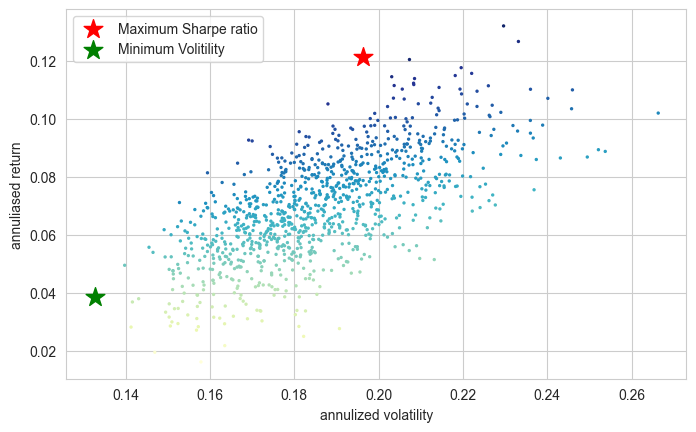

In [21]:
max_sr = rr_df.iloc[rr_df["sharpe_ratio"].idxmax()]
min_sd = rr_df.iloc[rr_df["std"].idxmin()]

fig_efficient_frontier, ax = plt.subplots(figsize=(8, 4.8))
ax.scatter(rr_df["std"], rr_df["return"], c=rr_df["sharpe_ratio"], cmap="YlGnBu", s=2)
ax.scatter(
    max_sr["std"],
    max_sr["return"],
    marker="*",
    color="r",
    s=200,
    label="Maximum Sharpe ratio",
)
ax.scatter(
    min_sd["std"],
    min_sd["return"],
    marker="*",
    color="g",
    s=200,
    label="Minimum Volitility",
)
ax.set_ylabel("annuliased return")
ax.set_xlabel("annulized volatility")
ax.legend()

The efficient frontier is not particularly apparent. 

According to this [page](https://quant.stackexchange.com/questions/44210/efficient-frontier-doesnt-look-good), the frontier can also be constructed with the combinations of just two efficient portfolios (e.g. the max sharpe and the min. variance portfolios).

$$
weights = w * \pi_{max\_sr} + (1 - w) * \pi_{min\_var}
$$

### Modern Portfolio Theory (MPT)

In [22]:
from pandas import DataFrame
from scipy.optimize import minimize


class EfficientPortfolio(Portfolio):
    def __init__(
        self,
        products_names: list,
        daily_prices: DataFrame,
        risk_free: float,
        weights=None,
    ) -> None:
        super().__init__(products_names, daily_prices, risk_free, weights)
        self.efficiency: str = "Not optimized"

    def _minus_SR(self, weights):
        self.weights = weights
        return -self.sharpe_ratio()

    def _port_vol_opt(self, weights):
        self.weights = weights
        return self.port_vol()

    def maximiaze_SR(self):
        # constraints, sum of weights = 1
        cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
        # bounds on weights: [0, 1]
        bnds = tuple((0, 1) for x in range(len(self.products)))
        # initial guess
        init_w = self.weights
        opts = minimize(
            self._minus_SR, init_w, method="SLSQP", bounds=bnds, constraints=cons
        )
        self.weights = opts.x
        self.efficiency = "Maximized Sharpe Ratio"

    def minimize_sd(self):
        # constraints, sum of weights = 1
        cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
        # bounds on weights: [0, 1]
        bnds = tuple((0, 1) for x in range(len(self.products)))
        # initial guess
        init_w = self.weights
        opts = minimize(
            self._port_vol_opt, init_w, method="SLSQP", bounds=bnds, constraints=cons
        )
        self.weights = opts.x
        self.efficiency = "Minimized volatility"

In [23]:
eff_port = EfficientPortfolio(
    port.products,
    port.daily_prices,
    port.risk_free,
)
print(eff_port.efficiency)
print(eff_port.weights)
print(eff_port.sharpe_ratio())
print(eff_port.port_vol())
print()
eff_port.maximiaze_SR()
print(eff_port.efficiency)
print(eff_port.weights)
print(eff_port.sharpe_ratio())
print()
eff_port.minimize_sd()
print(eff_port.efficiency)
print(eff_port.weights)
print(eff_port.port_vol())

Not optimized
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.2233747087048905
0.18006462666647688

Maximized Sharpe Ratio
[1.20177245e-16 0.00000000e+00 1.13478553e-17 0.00000000e+00
 0.00000000e+00 8.39127113e-02 0.00000000e+00 9.16087289e-01
 0.00000000e+00 1.19355110e-16]
0.7186096502341497

Minimized volatility
[0.04247242 0.08138358 0.03193741 0.14016576 0.02538793 0.00654217
 0.05545287 0.04787703 0.07392832 0.49485251]
0.11480484817668883


In [24]:
eff_port_max_sr = EfficientPortfolio(port.products, port.daily_prices, port.risk_free)
eff_port_max_sr.maximiaze_SR()
eff_port_min_sd = EfficientPortfolio(port.products, port.daily_prices, port.risk_free)
eff_port_min_sd.minimize_sd()

In [25]:
for _w in list(np.linspace(0, 1, num=10**1)):
    _combined_weights = (
        _w * eff_port_max_sr.weights + (1 - _w) * eff_port_min_sd.weights
    )
    print(_combined_weights)

[0.04291752 0.08028352 0.03106189 0.13944855 0.02542463 0.00655495
 0.05594133 0.04811253 0.07522074 0.49503435]
[0.03814891 0.07136313 0.02761057 0.12395427 0.02259967 0.01515026
 0.04972562 0.14455417 0.06686288 0.44003053]
[0.03338029 0.06244274 0.02415925 0.10845998 0.01977471 0.02374556
 0.04350992 0.24099581 0.05850502 0.38502672]
[0.02861168 0.05352235 0.02070792 0.0929657  0.01694975 0.03234087
 0.03729422 0.33743745 0.05014716 0.3300229 ]
[0.02384307 0.04460195 0.0172566  0.07747142 0.0141248  0.04093618
 0.03107851 0.43387909 0.0417893  0.27501908]
[0.01907445 0.03568156 0.01380528 0.06197713 0.01129984 0.04953148
 0.02486281 0.53032073 0.03343144 0.22001527]
[0.01430584 0.02676117 0.01035396 0.04648285 0.00847488 0.05812679
 0.01864711 0.62676237 0.02507358 0.16501145]
[0.00953723 0.01784078 0.00690264 0.03098857 0.00564992 0.0667221
 0.01243141 0.72320401 0.01671572 0.11000763]
[0.00476861 0.00892039 0.00345132 0.01549428 0.00282496 0.0753174
 0.0062157  0.81964565 0.008357

In [47]:
_rr_list = []
for _w in np.linspace(-0.2, 1.3, num=10**3):
    _combined_weights = (
        _w * eff_port_max_sr.weights + (1 - _w) * eff_port_min_sd.weights
    )
    _port = Portfolio(tickers, close_df, 0.03, weights=_combined_weights)
    _rr_list.append(
        [
            _port.port_ret(),
            _port.port_vol(),
            _port.sharpe_ratio(),
        ]
    )
rr_df = pd.DataFrame(data=_rr_list, columns=["return", "std", "sharpe_ratio"])

In [27]:
from itertools import compress

_rr_indi_l = []
for _w in np.identity(n=len(tickers)):
    _port = Portfolio(tickers, close_df, 0.03, weights=_w)
    _rr_indi_l.append(
        [
            _port.port_ret(),
            _port.port_vol(),
            _port.sharpe_ratio(),
            list(compress(tickers, _w))[0],
        ]
    )
rr_indi_df = pd.DataFrame(
    data=_rr_indi_l, columns=["return", "std", "sharpe_ratio", "ticker"]
)

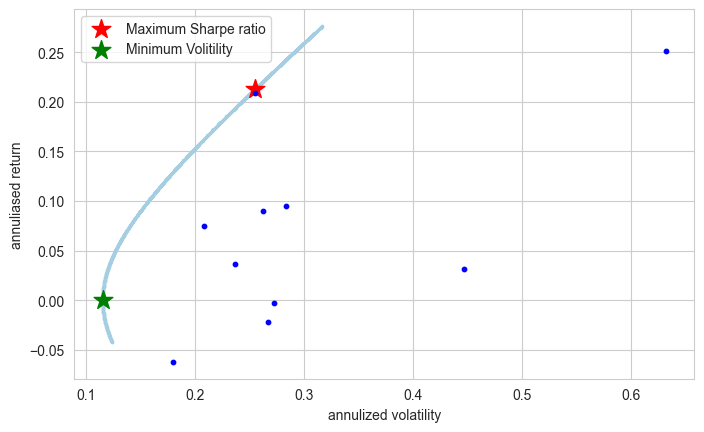

In [48]:
# max_sr = rr_df.iloc[rr_df["sharpe_ratio"].idxmax()]
min_sd = rr_df.iloc[rr_df["std"].idxmin()]

fig_efficient_frontier, ax = plt.subplots(figsize=(8, 4.8))
ax.scatter(rr_df["std"], rr_df["return"], s=2)
ax.scatter(
    eff_port_max_sr.port_vol(),
    eff_port_max_sr.port_ret(),
    marker="*",
    color="r",
    s=200,
    label="Maximum Sharpe ratio",
)
ax.scatter(
    min_sd["std"],
    min_sd["return"],
    marker="*",
    color="g",
    s=200,
    label="Minimum Volitility",
)
ax.scatter(
    rr_indi_df["std"],
    rr_indi_df["return"],
    s=10,
    c="b",
)
ax.set_ylabel("annuliased return")
ax.set_xlabel("annulized volatility")
ax.legend()